# Preprocessing Images for OCR

## Covered in this Video

1. Inverted Images
2. Rescaling
3. Binarization
4. Noise Removal
5. Dilation and Erosion
6. Rotation / Deskewing
7. Removing Borders
8. Missing Borders
9. Transparency / Alpha Channel

## 00: Opening an Image

In [86]:
import cv2
from matplotlib import pyplot as plt
image_file = "codes/workspace/images/plates/IMG-20230425-WA003.jpg"
img = cv2.imread(image_file)


In [87]:
#https://stackoverflow.com/questions/28816046/
#displaying-different-images-with-actual-size-in-matplotlib-subplot
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

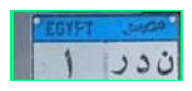

In [88]:
display(image_file)

## 01: Inverted Images

In [89]:
inverted_image = cv2.bitwise_not(img)
cv2.imwrite("codes/workspace/images/plates/inverted.jpg", inverted_image)

True

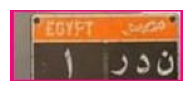

In [90]:
display("codes/workspace/images/plates/inverted.jpg")

## 02: Rescaling

## 03: Binarization

In [91]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


In [92]:
gray_image = grayscale(img)
cv2.imwrite("codes/workspace/images/plates/gray.jpg", gray_image)

True

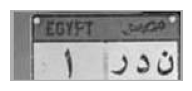

In [93]:
display("codes/workspace/images/plates/gray.jpg")

In [100]:
thresh, im_bw = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY)
cv2.imwrite("codes/workspace/images/plates/bw_image.jpg", im_bw)

True

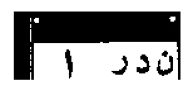

In [101]:
display("codes/workspace/images/plates/bw_image.jpg")

## 04: Noise Removal

In [102]:
def noise_removal(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)

In [103]:
no_noise = noise_removal(im_bw)
cv2.imwrite("codes/workspace/images/plates/no_noise.jpg", no_noise)

True

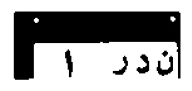

In [104]:
display("codes/workspace/images/plates/no_noise.jpg")

## Dilation and Erosion

In [105]:
def thin_font(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

In [106]:
eroded_image = thin_font(no_noise)
cv2.imwrite("codes/workspace/images/plates/eroded_image.jpg", eroded_image)

True

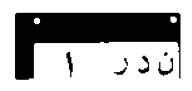

In [107]:
display("codes/workspace/images/plates/eroded_image.jpg")

In [108]:
def thick_font(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

In [109]:
dilated_image = thick_font(no_noise)
cv2.imwrite("codes/workspace/images/plates/dilated_image.jpg", dilated_image)

True

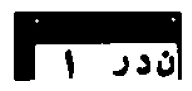

In [110]:
display("codes/workspace/images/plates/dilated_image.jpg")

## 06: Rotation / Deskewing

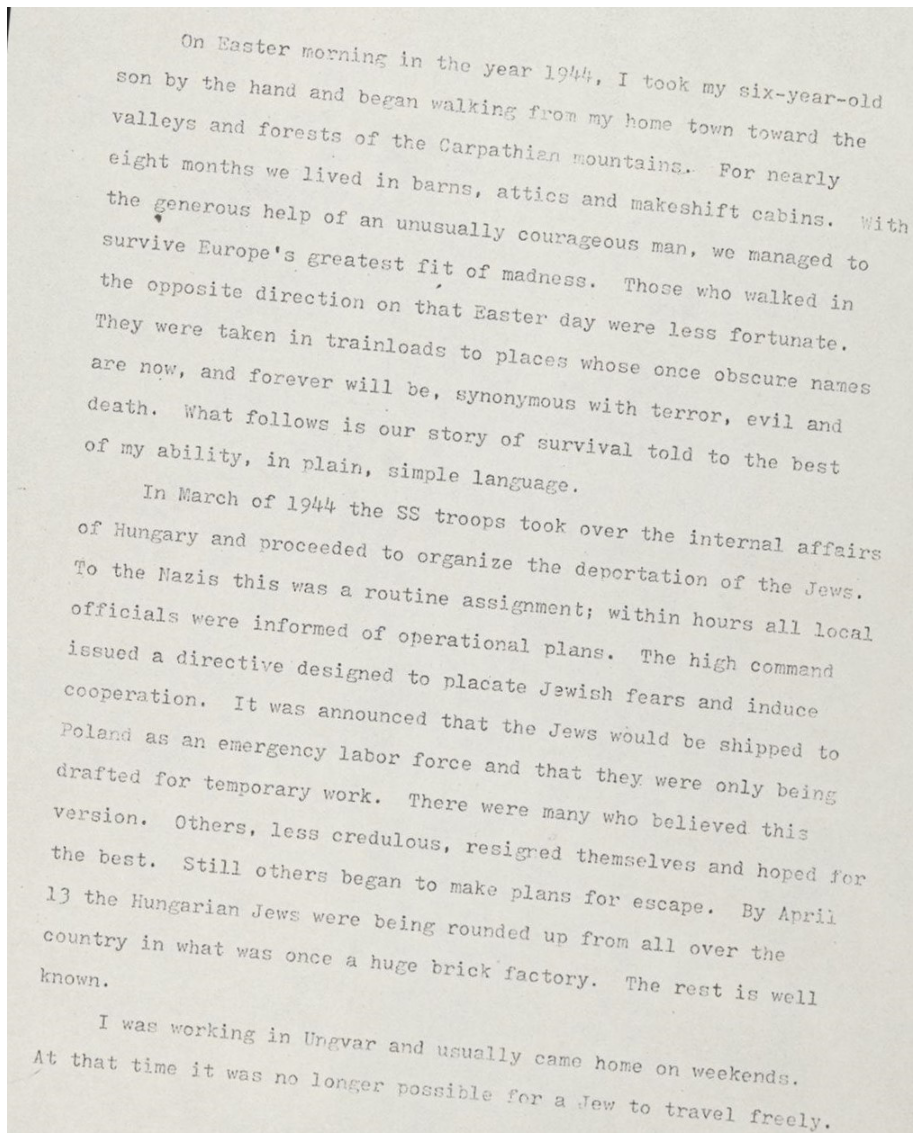

In [20]:
new = cv2.imread("data/page_01_rotated.JPG")
display("data/page_01_rotated.JPG")

In [21]:
#https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df
import numpy as np

def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

In [22]:
# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

In [23]:
fixed = deskew(new)
cv2.imwrite("temp/rotated_fixed.jpg", fixed)

28


True

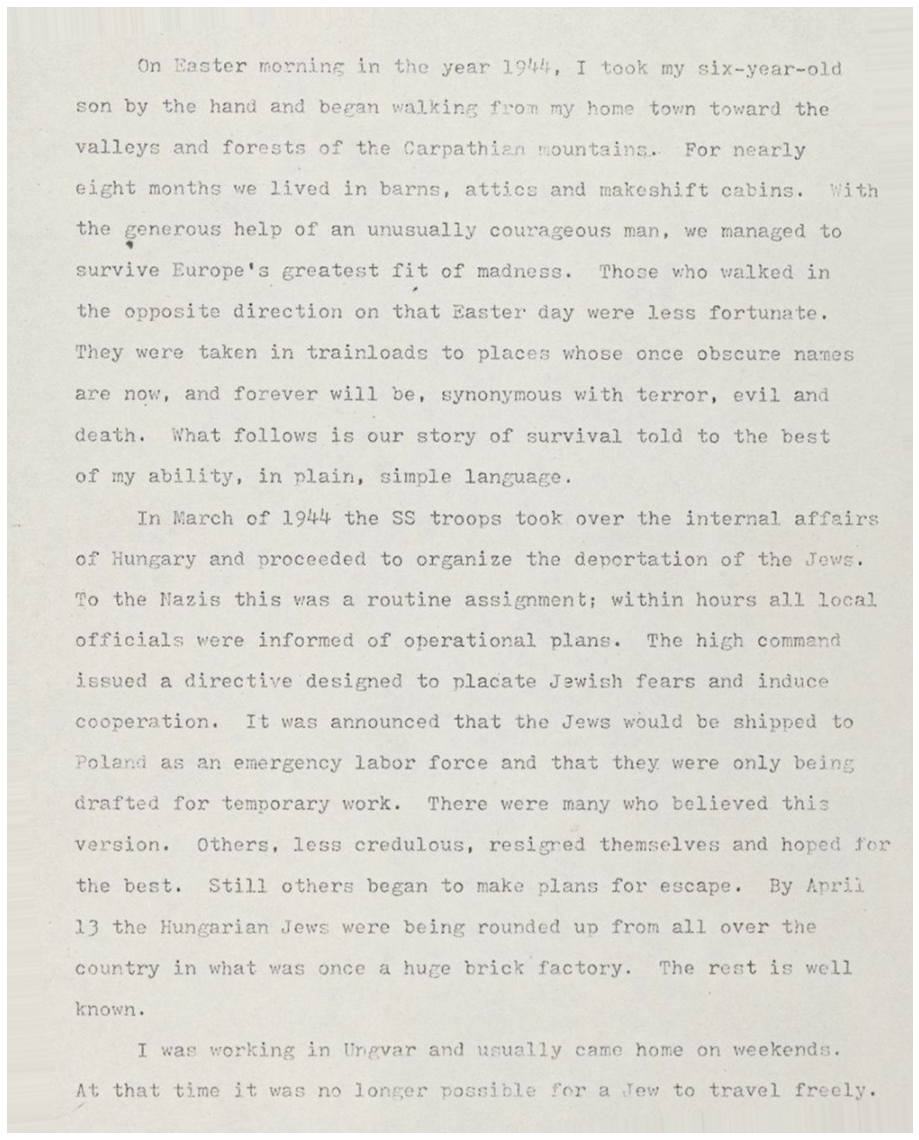

In [24]:
display("temp/rotated_fixed.jpg")

## 07: Removing Borders

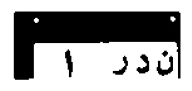

In [111]:
display("codes/workspace/images/plates/no_noise.jpg")

In [112]:
def remove_borders(image):
    contours, heiarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv2.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

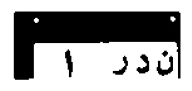

In [113]:
no_borders = remove_borders(no_noise)
cv2.imwrite("codes/workspace/images/plates/no_borders.jpg", no_borders)
display('codes/workspace/images/plates/no_borders.jpg')

In [146]:
from PIL import Image
def crop_borders(image_path):
    # Open the image using PIL
    img = Image.open(image_path)

    # Get the size of the image
    width, height = img.size

    # Initialize variables for the border size
    left = width
    right = 0
    top = height
    bottom = 0

    # Loop through each pixel in the image
    for x in range(width):
        for y in range(height):
            # Get the color of the pixel at (x, y)
            pixel = img.getpixel((x, y))

            # If the pixel is white, update the left border
            if pixel == (255, 255, 255):
                if x < left:
                    left = x

            # If the pixel is white, update the right border
            if pixel == (255, 255, 255):
                if x > right:
                    right = x

            # If the pixel is white, update the top border
            if pixel == (255, 255, 255):
                if y < top:
                    top = y

            # If the pixel is white, update the bottom border
            if pixel == (255, 255, 255):
                if y > bottom:
                    bottom = y

    # Crop the image based on the border size
    cropped_img = img.crop((left, top, right + 1, bottom + 1))

    # Save the cropped image
    cropped_img.save("codes/workspace/images/plates/cropped_image.png")

    # Return the cropped image
    return cropped_img

In [147]:
crop_borders('codes/workspace/images/plates/no_borders.jpg')

ValueError: Coordinate 'right' is less than 'left'

## 08: Missing Borders

In [57]:
color = [255, 255, 255]
top, bottom, left, right = [150]*4

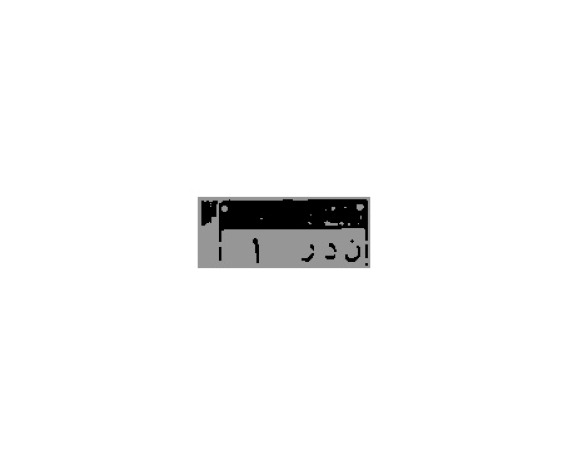

In [58]:
image_with_border = cv2.copyMakeBorder(no_borders, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
cv2.imwrite("codes/workspace/images/plates/image_with_border.jpg", image_with_border)
display("codes/workspace/images/plates/image_with_border.jpg")

## 09: Transparency / Alpha Channel